#### Aula 26 – Redes Neurais Convolucionais
##### Nesse exercício irei fazer uma adptação com relação ao tutorial utilizado, pois o mesmo trata de recursos do opencv porém na linguagem C++ ,e como estou realizando realizando todas as aulas em python irei mostrar a construção de uma rede convolucional bem simples em pytorch utilizando o dataset MINIST.

In [2]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms
torch.__version__

'1.4.0+cpu'

In [3]:
torch.manual_seed(123)

In [4]:
transform = transforms.ToTensor()

In [5]:
train = datasets.MNIST(root = '.',train = 'True',download = True,transform = transform)

Extracting .\MNIST\raw\train-images-idx3-ubyte.gz to .\MNIST\raw


Extracting .\MNIST\raw\train-labels-idx1-ubyte.gz to .\MNIST\raw


Extracting .\MNIST\raw\t10k-images-idx3-ubyte.gz to .\MNIST\raw


Extracting .\MNIST\raw\t10k-labels-idx1-ubyte.gz to .\MNIST\raw
Processing...
Done!


In [6]:
test = datasets.MNIST(root = '.',train = False, download = True, transform=transform)

In [7]:
train_loader = torch.utils.data.DataLoader(train,batch_size = 128)
test_loader = torch.utils.data.DataLoader(test,batch_size=128)

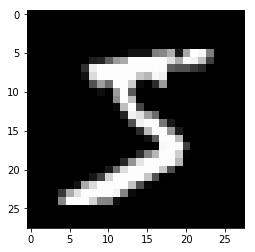

In [8]:
imagem = next(iter(train_loader))[0][0].view(28,28)
plt.imshow(imagem,cmap='gray')
#Imagem retorna (batch(n de imagens),canais(cinza ou rgb),shape(x,y))
#view retorna apenas a imagem mudando o size

### Construção do Modelo

In [9]:
class classificador(nn.Module):
    def __init__(self):
        super().__init__()
        
        ##Estrutura da Parte Convolucional
        self.conv1 = nn.Conv2d(in_channels = 1,out_channels = 32,kernel_size=(3,3))
        #in_channels = 3 p/ rgb 
        #out_channels = 32 filtros        
        self.conv2 = nn.Conv2d(32,32,(3,3))
        #conv2 : entrada
        #recebe os 32 filtros da camada anterior conv1
        
        self.activation = nn.ReLU()
        self.bnorm = nn.BatchNorm2d(num_features = 32)
        self.pool = nn.MaxPool2d(kernel_size=(2,2))
        self.flatten = nn.Flatten()
        
        
        ##Estrutura da Rede Neural Densa
    
        #800 -> 128 -> 128 ->10 digitos
        #output = (input - dimfilter + 1)/stride
        #stride -> de quantos em quantos pixels vai andar, default =1 
        #Convolução 1:(28 - 3 + 1 / 1) = 26x26
        #pooling 1: 13x13 (divide por 2)
        #Convolução 2: (13 - 3 + 1/1) = 11x11
        #pooling 2: 5x5
        #5*5* 32 detectores
        self.linear1 = nn.Linear(in_features = 32*5*5,out_features=128)
        self.linear2 = nn.Linear(128,128)
        self.output = nn.Linear(128,10)
        self.dropout = nn.Dropout(p = 0.2)
        #Zerar 20% dos neuronios
    def foward(self,X):
        X = self.pool(self.bnorm(self.activation(self.conv1(X))))
        X = self.pool(self.bnorm(self.activation(self.conv2(X))))   
        X = self.flatten(X)
        
        X = self.dropout(self.activation(self.linear1(X)))
        X = self.dropout(self.activation(self.linear2(X)))
        X = self.output(X)
        
        return X

In [10]:
net = classificador()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

### Treinamento

In [11]:
device = torch.device('cpu')
device

device(type='cpu')

In [12]:
net.to(device)

classificador(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (activation): ReLU()
  (bnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten()
  (linear1): Linear(in_features=800, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [13]:
def training_loop(loader,epoch):
    #loader dados para validação
    running_loss = 0
    running_accuracy = 0
    
    for i , data in enumerate(loader):
        inputs,labels = data
        #inputs = pixels, labels = respostas
        inputs,labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = net.foward(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        #back propagation
        
        optimizer.step()
        #aualiza os pesos
        
        running_loss += loss.item()
        
        ps = F.softmax(outputs)
        top_p,top_class = ps.topk(k=1,dim=1)
        equals = top_class == labels.view(*top_class.shape)
        
        accuracy = torch.mean(equals.type(torch.float))
        
        running_accuracy += accuracy
        
        #Dados referentes a esse loop
        print('\rÉpoca {:3d} - Loop {:3d} de {:3d} : perda {:03.2f} - precisao {:03.2f}'.format(epoch+1,i+1,len(loader),loss,accuracy),end = '\r' )
    
    #Dados referentes a essa época
    print('\rÉpoca {:3d} FINALIZADA: perda {:.5f} - precisao {:.5f}'.format(epoch+1,running_loss/len(loader),running_accuracy/len(loader)))

In [14]:
for epoch in range(5):
    print('Treinando ...')
    training_loop(train_loader,epoch)
    net.eval()
    print('Validando...')
    training_loop(test_loader,epoch)
    net.train()

Treinando ...


C:\Users\willi\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Época   1 FINALIZADA: perda 0.15935 - precisao 0.9536299
Validando...
Época   1 FINALIZADA: perda 0.16087 - precisao 0.9535200
Treinando ...
Época   2 FINALIZADA: perda 0.05280 - precisao 0.9842599
Validando...
Época   2 FINALIZADA: perda 0.07056 - precisao 0.9794300
Treinando ...
Época   3 FINALIZADA: perda 0.03828 - precisao 0.9891399
Validando...
Época   3 FINALIZADA: perda 0.04416 - precisao 0.9879400
Treinando ...
Época   4 FINALIZADA: perda 0.03155 - precisao 0.9909599
Validando...
Época   4 FINALIZADA: perda 0.04104 - precisao 0.9876400
Treinando ...
Época   5 FINALIZADA: perda 0.02521 - precisao 0.9925299
Validando...
Época   5 FINALIZADA: perda 0.02784 - precisao 0.9916900


### Avaliação do Modelo

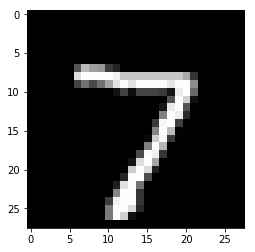

In [15]:
imagem = next(iter(test_loader))[0][0].view(28,28)
plt.imshow(imagem,cmap ='gray')

In [16]:
imagem = imagem.view(1,1,28,28)

In [17]:
net.eval()
imagem = imagem.to(device)

In [20]:
previsao = net.foward(imagem)
previsao = F.softmax(previsao)

C:\Users\willi\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [21]:
previsao = previsao.cpu().detach().numpy()

In [22]:
resultado = np.argmax(previsao)

In [23]:
resultado

7

###### Obs: Note que a precisão é alta pois o dataset de treinamento é também utilizado para a validação e testes já que é apenas uma demonstração do funcionamento das CNN.